In [12]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [13]:
pip install BeautifulSoup4

Note: you may need to restart the kernel to use updated packages.


In [14]:
pip install lxml

Note: you may need to restart the kernel to use updated packages.


In [15]:
from bs4 import BeautifulSoup
import requests

In [16]:
#Scraping using Beautiful soup
url = "https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=945633050."
soup = BeautifulSoup(requests.get(url).text, 'lxml')
table=soup.find('table')

#Writing in tabular form and creating csv file
data=""
for i in table.find_all('tr'):
    row1=""
    for tds in i.find_all('td'):
        row1 = row1 + "," + tds.text
    data=data+row1[1:]
file=open("data.csv","wb")
file.write(bytes(data,encoding="ascii",errors="ignore"))

#Creating a pandas data frame
df = pd.DataFrame(columns=["Postalcode","Borough","Neighbourhood"])
df = pd.read_csv('data.csv',header=None)
df.columns=["Postalcode","Borough","Neighbourhood"]
df.head()

Postalcode           Borough     Neighbourhood
0        M1A      Not assigned      Not assigned
1        M2A      Not assigned      Not assigned
2        M3A        North York         Parkwoods
3        M4A        North York  Victoria Village
4        M5A  Downtown Toronto      Harbourfront

In [17]:
#Removing rows with Borough = Not assigned
noboroughs = df.index[df['Borough'] == 'Not assigned']
df.drop(df.index[noboroughs], inplace=True)
df.reset_index(drop=True, inplace=True)

#Not assigned neigbourhood = borough
noneighbor = df.index[df['Neighbourhood'] == 'Not assigned']
for i in noneighbor:
    df['Neighbourhood'][i] = df['Borough'][i]

#Removing Duplicates
temp=df.groupby('Postalcode')['Neighbourhood'].apply(lambda x: "%s" % ', '.join(x))
temp=temp.reset_index(drop=False)
temp.rename(columns={'Neighbourhood':'tempneighbor'},inplace=True)
df_final = pd.merge(df, temp, on='Postalcode')
df_final.drop(['Neighbourhood'],axis=1,inplace=True)
df_final.drop_duplicates(inplace=True)
df_final.rename(columns={'tempneighbor':'Neighbourhood'},inplace=True)
df_final.head(10)

Postalcode           Borough                     Neighbourhood
0         M3A        North York                         Parkwoods
1         M4A        North York                  Victoria Village
2         M5A  Downtown Toronto                      Harbourfront
3         M6A        North York  Lawrence Heights, Lawrence Manor
5         M7A  Downtown Toronto                      Queen's Park
6         M9A         Etobicoke                  Islington Avenue
7         M1B       Scarborough                    Rouge, Malvern
9         M3B        North York                   Don Mills North
10        M4B         East York   Woodbine Gardens, Parkview Hill
12        M5B  Downtown Toronto          Ryerson, Garden District

In [18]:
# reading geo location data
geodata=pd.read_csv('http://cocl.us/Geospatial_data')
#Merging data frames
geodata.rename(columns={'Postal Code':'Postalcode'},inplace=True)
merged= pd.merge(geodata,df_final, on='Postalcode')
#Rearranging
merged=merged[['Postalcode','Borough','Neighbourhood','Latitude','Longitude']]
merged.head()

Postalcode      Borough                           Neighbourhood   Latitude  \
0        M1B  Scarborough                          Rouge, Malvern  43.806686   
1        M1C  Scarborough  Highland Creek, Rouge Hill, Port Union  43.784535   
2        M1E  Scarborough       Guildwood, Morningside, West Hill  43.763573   
3        M1G  Scarborough                                  Woburn  43.770992   
4        M1H  Scarborough                               Cedarbrae  43.773136   

   Longitude  
0 -79.194353  
1 -79.160497  
2 -79.188711  
3 -79.216917  
4 -79.239476

In [19]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[43.65,-79.38], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(merged['Latitude'], merged['Longitude'], merged['Borough'], merged['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.9,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [20]:
#filtering downtown
downtown = merged[merged['Borough'] == 'Downtown Toronto'].reset_index(drop=True)
downtown

Postalcode           Borough  \
0         M4W  Downtown Toronto   
1         M4X  Downtown Toronto   
2         M4Y  Downtown Toronto   
3         M5A  Downtown Toronto   
4         M5B  Downtown Toronto   
5         M5C  Downtown Toronto   
6         M5E  Downtown Toronto   
7         M5G  Downtown Toronto   
8         M5H  Downtown Toronto   
9         M5J  Downtown Toronto   
10        M5K  Downtown Toronto   
11        M5L  Downtown Toronto   
12        M5S  Downtown Toronto   
13        M5T  Downtown Toronto   
14        M5V  Downtown Toronto   
15        M5W  Downtown Toronto   
16        M5X  Downtown Toronto   
17        M6G  Downtown Toronto   
18        M7A  Downtown Toronto   

                                        Neighbourhood   Latitude  Longitude  
0                                            Rosedale  43.679563 -79.377529  
1                         Cabbagetown, St. James Town  43.667967 -79.367675  
2                                Church and Wellesley  43.665860 -79.383160  
3                                        Harbourfront  43.654260 -79.360636  
4                            Ryerson, Garden District  43.657162 -79.378937  
5                                      St. James Town  43.651494 -79.375418  
6                                         Berczy Park  43.644771 -79.373306  
7                                  Central Bay Street  43.657952 -79.387383  
8                            Adelaide, King, Richmond  43.650571 -79.384568  
9   Harbourfront East, Toronto Islands, Union Station  43.640816 -79.381752  
10           Design Exchange, Toronto Dominion Centre  43.647177 -79.381576  
11                     Commerce Court, Victoria Hotel  43.648198 -79.379817  
12                     Harbord, University of Toronto  43.662696 -79.400049  
13          Chinatown, Grange Park, Kensington Market  43.653206 -79.400049  
14  CN Tower, Bathurst Quay, Island airport, Harbo...  43.628947 -79.394420  
15                    Stn A PO Boxes 25 The Esplanade  43.646435 -79.374846  
16             First Canadian Place, Underground city  43.648429 -79.382280  
17                                           Christie  43.669542 -79.422564  
18                                       Queen's Park  43.662301 -79.389494

In [21]:
#Foursquare Credentials
CLIENT_ID = 'SVDTYH3LYUNDNYPUTAUP2XORBKWXEGGJEZOD0CUWULIMMJUG'
CLIENT_SECRET ='TANECVXBFKBHE5SNDOSJH5BO5TASHN3O1NIFKG1H44S45CWG' 
VERSION = '20180605'

In [22]:
#Retrieving venues near Habord Neighborhood
LIMIT = 200
radius = 1000 
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    43.662696, 
    -79.400049, 
    radius, 
    LIMIT)
url 
results1 = requests.get(url).json()

In [23]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
venues = results1['response']['groups'][0]['items']    
nearby_venues1 = json_normalize(venues)
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues1 =nearby_venues1.loc[:, filtered_columns]
nearby_venues1['venue.categories'] = nearby_venues1.apply(get_category_type, axis=1)
nearby_venues1.columns = [col.split(".")[-1] for col in nearby_venues1.columns]
nearby_venues1.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  if sys.path[0] == '':


name           categories        lat        lng
0                              Yasu  Japanese Restaurant  43.662837 -79.403217
1                              Rasa           Restaurant  43.662757 -79.403988
2               The Dessert Kitchen         Dessert Shop  43.662823 -79.402746
3  Her Father's Cider Bar + Kitchen             Beer Bar  43.662448 -79.404703
4                       Piano Piano   Italian Restaurant  43.662949 -79.402898

In [24]:
#retreinving venues near Queens Park
LIMIT = 100
radius = 1000 
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    43.662301, 
    -79.389494, 
    radius, 
    LIMIT)
url 
results2 = requests.get(url).json()
venues = results2['response']['groups'][0]['items']    
nearby_venues2 = json_normalize(venues)
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues2 =nearby_venues2.loc[:, filtered_columns]
nearby_venues2['venue.categories'] = nearby_venues2.apply(get_category_type, axis=1)
nearby_venues2.columns = [col.split(".")[-1] for col in nearby_venues2.columns]
nearby_venues2.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  from ipykernel import kernelapp as app


name           categories        lat        lng
0        Queen's Park                 Park  43.663946 -79.392180
1      Neo Coffee Bar          Coffee Shop  43.660140 -79.385870
2            Mercatto   Italian Restaurant  43.660391 -79.387664
3        Central YMCA  Distribution Center  43.663083 -79.385025
4  The Yoga Sanctuary          Yoga Studio  43.661499 -79.383636

In [25]:
#all venues near University of Toronto
all_venues=pd.merge(nearby_venues2,nearby_venues1,how='outer')
all_venues.drop_duplicates(inplace=True)
all_venues.head(10)

name           categories        lat        lng
0        Queen's Park                 Park  43.663946 -79.392180
1      Neo Coffee Bar          Coffee Shop  43.660140 -79.385870
2            Mercatto   Italian Restaurant  43.660391 -79.387664
3        Central YMCA  Distribution Center  43.663083 -79.385025
4  The Yoga Sanctuary          Yoga Studio  43.661499 -79.383636
5           The Alley      Bubble Tea Shop  43.665922 -79.385567
6      Jimmy's Coffee          Coffee Shop  43.658421 -79.385613
7            Bar Volo             Beer Bar  43.665462 -79.385692
8           Starbucks          Coffee Shop  43.659456 -79.390411
9   College Park Area                 Park  43.659751 -79.384911

In [26]:
print('There are {} uniques categories.'.format(len(all_venues['categories'].unique())))

There are 90 uniques categories.


In [27]:
# create map of university of Toronto using latitude and longitude values
map_univtoronto = folium.Map(location=[43.6629,-79.3957], zoom_start=15)

# add markers to map
for lat, lng, name, categories in zip(all_venues['lat'], all_venues['lng'], all_venues['categories'], all_venues['name']):
    label = '{}, {}'.format(name,categories)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.9,
        parse_html=False).add_to(map_univtoronto)  
    
map_univtoronto

In [28]:
#One hot Coding
venues_onehot = pd.get_dummies(all_venues[['categories']], prefix="", prefix_sep="")
venues_onehot.head()

Art Gallery  Arts & Crafts Store  Bakery  Bar  Beer Bar  \
0            0                    0       0    0         0   
1            0                    0       0    0         0   
2            0                    0       0    0         0   
3            0                    0       0    0         0   
4            0                    0       0    0         0   

   Belgian Restaurant  Bookstore  Breakfast Spot  Brewery  Bubble Tea Shop  \
0                   0          0               0        0                0   
1                   0          0               0        0                0   
2                   0          0               0        0                0   
3                   0          0               0        0                0   
4                   0          0               0        0                0   

   Burger Joint  Burrito Place  Café  Caribbean Restaurant  Cheese Shop  \
0             0              0     0                     0            0   
1             0              0     0                     0            0   
2             0              0     0                     0            0   
3             0              0     0                     0            0   
4             0              0     0                     0            0   

   Chinese Restaurant  Clothing Store  Coffee Shop  College Gym  \
0                   0               0            0            0   
1                   0               0            1            0   
2                   0               0            0            0   
3                   0               0            0            0   
4                   0               0            0            0   

   College Theater  Comfort Food Restaurant  Comic Shop  Concert Hall  \
0                0                        0           0             0   
1                0                        0           0             0   
2                0                        0           0             0   
3                0                        0           0             0   
4                0                        0           0             0   

   Cosmetics Shop  Creperie  Dance Studio  Department Store  Dessert Shop  \
0               0         0             0                 0             0   
1               0         0             0                 0             0   
2               0         0             0                 0             0   
3               0         0             0                 0             0   
4               0         0             0                 0             0   

   Diner  Discount Store  Distribution Center  Doner Restaurant  \
0      0               0                    0                 0   
1      0               0                    0                 0   
2      0               0                    0                 0   
3      0               0                    1                 0   
4      0               0                    0                 0   

   Dumpling Restaurant  Eastern European Restaurant  Ethiopian Restaurant  \
0                    0                            0                     0   
1                    0                            0                     0   
2                    0                            0                     0   
3                    0                            0                     0   
4                    0                            0                     0   

   Farmers Market  Fish Market  French Restaurant  Gastropub  Gay Bar  \
0               0            0                  0          0        0   
1               0            0                  0          0        0   
2               0            0                  0          0        0   
3               0            0                  0          0        0   
4               0            0                  0          0        0   

   General Entertainment  Gift Shop  Gourmet Shop  Greek Restaurant  \
0                      0     

In [29]:
sum=venues_onehot.sum(axis=0)

In [30]:
places=venues_onehot.columns
places_df=pd.DataFrame({'col':places})
places_df
to_drop=['Rest','Bar','Caf','Dess','Ice','Joint','Spot','Place','Tea','Pastry','Coffee','Pub','Brew','Bak','Market','Shop','Groce','Store','Din','Distri']
for i in to_drop:
 places_df =places_df[~places_df.col.str.contains(i)]
non_food=[]
for i in places_df['col']:
 non_food.append(i)

In [31]:
sum_food=sum.drop(non_food)
nonfood_onehot=venues_onehot.loc[:,non_food]
sum_nonfood=nonfood_onehot.sum(axis=0)

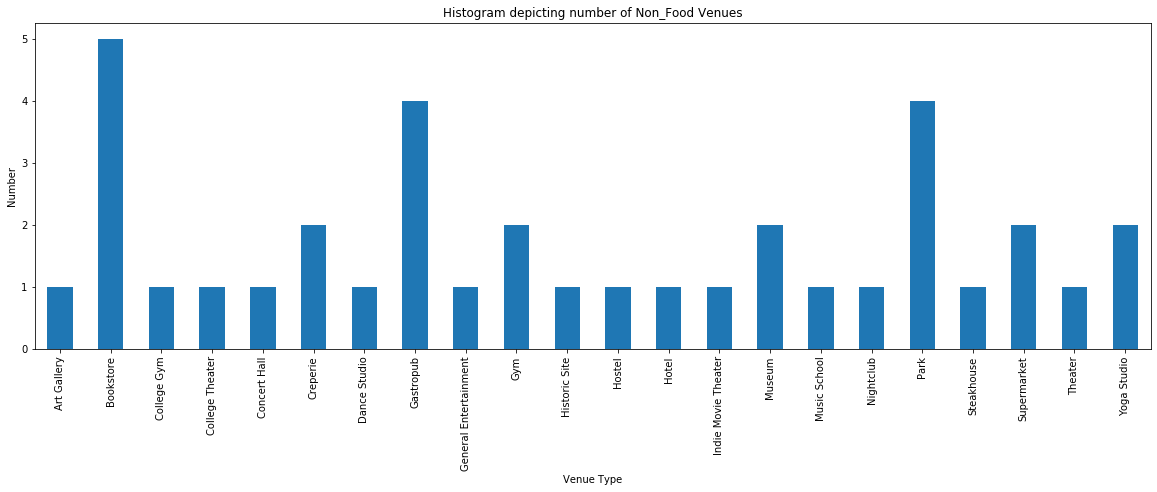

In [32]:

import matplotlib as mpl
import matplotlib.pyplot as plt
sum_nonfood.plot(kind='bar', figsize=(20,6))

plt.xlabel('Venue Type') # add to x-label to the plot
plt.ylabel('Number') # add y-label to the plot
plt.title('Histogram depicting number of Non_Food Venues')

plt.show()

In [33]:
places=venues_onehot.columns
places_df=pd.DataFrame({'col':places})
places_df
to_drop=['Rest','Bar','Caf','Dess','Ice','Joint','Spot','Place','Tea','Pastry','Coffee','Pub','Brew','Bak']
for i in to_drop:
 places_df =places_df[~places_df.col.str.contains(i)]
non_food=[]
for i in places_df['col']:
 non_food.append(i)
sum_food=sum.drop(non_food)

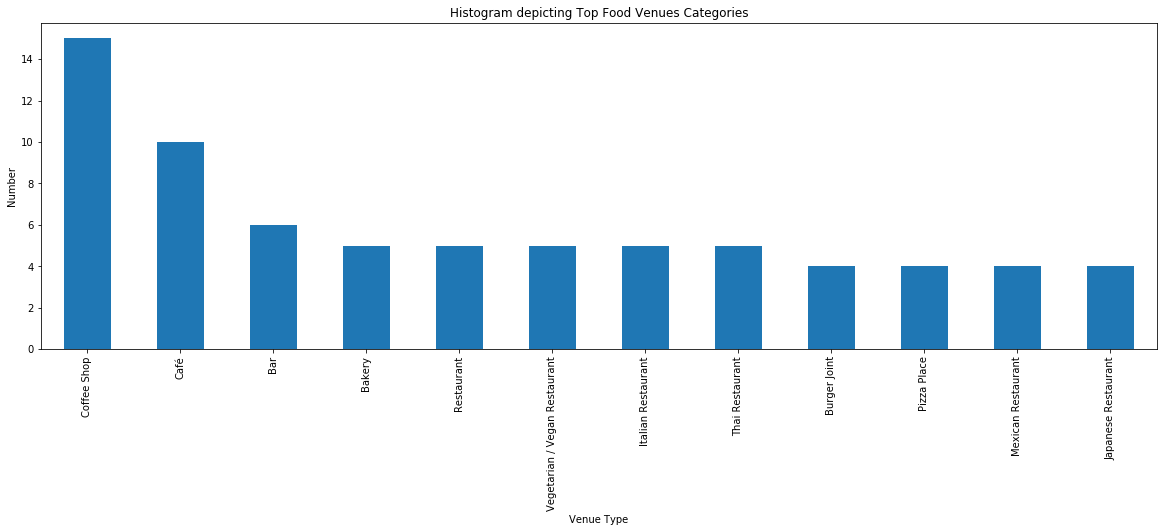

In [130]:
sum_foodsorted=sum_food.sort_values(axis=0,ascending=False)
import matplotlib as mpl
import matplotlib.pyplot as plt
sum_foodsorted.iloc[0:12].plot(kind='bar', figsize=(20,6))

plt.xlabel('Venue Type') # add to x-label to the plot
plt.ylabel('Number') # add y-label to the plot
plt.title('Histogram depicting Top Food Venues Categories')

plt.show()

In [34]:
#Retrieving all venues in Downtown Toronto
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


In [40]:

downtown_venues = getNearbyVenues(names=downtown['Neighbourhood'],
                                   latitudes=downtown['Latitude'],
                                   longitudes=downtown['Longitude']
                                  )


Rosedale
Cabbagetown, St. James Town
Church and Wellesley
Harbourfront
Ryerson, Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide, King, Richmond
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Commerce Court, Victoria Hotel
Harbord, University of Toronto
Chinatown, Grange Park, Kensington Market
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place, Underground city
Christie
Queen's Park


In [41]:
downtown_venues.groupby('Neighborhood').count()

Neighborhood Latitude  \
Neighborhood                                                                
Adelaide, King, Richmond                                              100   
Berczy Park                                                            55   
CN Tower, Bathurst Quay, Island airport, Harbou...                     18   
Cabbagetown, St. James Town                                            42   
Central Bay Street                                                     82   
Chinatown, Grange Park, Kensington Market                              87   
Christie                                                               18   
Church and Wellesley                                                   89   
Commerce Court, Victoria Hotel                                        100   
Design Exchange, Toronto Dominion Centre                              100   
First Canadian Place, Underground city                                100   
Harbord, University of Toronto                                         37   
Harbourfront                                                           47   
Harbourfront East, Toronto Islands, Union Station                     100   
Queen's Park                                                           42   
Rosedale                                                                4   
Ryerson, Garden District                                              100   
St. James Town                                                        100   
Stn A PO Boxes 25 The Esplanade                                        95   

                                                    Neighborhood Longitude  \
Neighborhood                                                                 
Adelaide, King, Richmond                                               100   
Berczy Park                                                             55   
CN Tower, Bathurst Quay, Island airport, Harbou...                      18   
Cabbagetown, St. James Town                                             42   
Central Bay Street                                                      82   
Chinatown, Grange Park, Kensington Market                               87   
Christie                                                                18   
Church and Wellesley                                                    89   
Commerce Court, Victoria Hotel                                         100   
Design Exchange, Toronto Dominion Centre                               100   
First Canadian Place, Underground city                                 100   
Harbord, University of Toronto                                          37   
Harbourfront                                                            47   
Harbourfront East, Toronto Islands, Union Station                      100   
Queen's Park                                                            42   
Rosedale                                                                 4   
Ryerson, Garden District                                               100   
St. James Town                                                         100   
Stn A PO Boxes 25 The Esplanade                                         95   

                                                    Venue  Venue Latitude  \
Neighborhood                                                                
Adelaide, King, Richmond                              100             100   
Berczy Park                                            55              55   
CN Tower, Bathurst Quay, Island airport, Harbou...     18              18   
Cabbagetown, St. James Town                            42              42   
Central Bay Street                                     82              82   
Chinatown, Grange Park, Kensington Market              87              87   
Christie                                               18              18   
Church and Wellesley                                   89              89   
Commerce Court, Victoria 

In [92]:
print('There are {} uniques categories.'.format(len(downtown_venues['Venue Category'].unique())))

There are 208 uniques categories.


In [42]:
# one hot encoding
downtown_onehot = pd.get_dummies(downtown_venues[['Venue Category']], prefix="", prefix_sep="")
downtown_onehot.head()

Afghan Restaurant  Airport  Airport Food Court  Airport Gate  \
0                  0        0                   0             0   
1                  0        0                   0             0   
2                  0        0                   0             0   
3                  0        0                   0             0   
4                  0        0                   0             0   

   Airport Lounge  Airport Service  Airport Terminal  American Restaurant  \
0               0                0                 0                    0   
1               0                0                 0                    0   
2               0                0                 0                    0   
3               0                0                 0                    0   
4               0                0                 0                    0   

   Antique Shop  Aquarium  Art Gallery  Art Museum  Arts & Crafts Store  \
0             0         0            0           0                    0   
1             0         0            0           0                    0   
2             0         0            0           0                    0   
3             0         0            0           0                    0   
4             0         0            0           0                    0   

   Asian Restaurant  Athletics & Sports  BBQ Joint  Baby Store  Bagel Shop  \
0                 0                   0          0           0           0   
1                 0                   0          0           0           0   
2                 0                   0          0           0           0   
3                 0                   0          0           0           0   
4                 0                   0          0           0           0   

   Bakery  Bank  Bar  Baseball Stadium  Basketball Stadium  Beach  \
0       0     0    0                 0                   0      0   
1       0     0    0                 0                   0      0   
2       0     0    0                 0                   0      0   
3       0     0    0                 0                   0      0   
4       0     0    0                 0                   0      0   

   Bed & Breakfast  Beer Bar  Beer Store  Belgian Restaurant  Bistro  \
0                0         0           0                   0       0   
1                0         0           0                   0       0   
2                0         0           0                   0       0   
3                0         0           0                   0       0   
4                0         0           0                   0       0   

   Boat or Ferry  Bookstore  Boutique  Brazilian Restaurant  Breakfast Spot  \
0              0          0         0                     0               0   
1              0          0         0                     0               0   
2              0          0         0                     0               0   
3              0          0         0                     0               0   
4              0          0         0                     0               0   

   Brewery  Bubble Tea Shop  Building  Burger Joint  Burrito Place  Butcher  \
0        0                0         0             0              0        0   
1        0                0         0             0              0        0   
2        0                0         0             0              0        0   
3        0                0         0             0              0        0   
4        0                0         0             0              0        0   

   Café  Camera Store  Candy Store  Caribbean Restaurant  Cheese Shop  \
0     0             0            0                     0            0   
1     0             0            0                     0            0   
2     0             0            0                     0            0   
3     0             0            0                     0            0   
4     0             0            0                    

In [46]:
#Number of All popular venues in downtown toronto
sum=downtown_onehot.sum(axis=0)
sum_sorted=sum.sort_values(axis=0,ascending=False)
sum_sorted

Coffee Shop                        137
Café                                66
Restaurant                          51
Hotel                               34
Japanese Restaurant                 32
Italian Restaurant                  31
Bakery                              29
Seafood Restaurant                  24
Bar                                 24
Park                                22
Beer Bar                            20
Gastropub                           19
American Restaurant                 18
Thai Restaurant                     18
Pizza Place                         17
Gym                                 17
Vegetarian / Vegan Restaurant       16
Pub                                 15
Clothing Store                      14
Breakfast Spot                      14
Sandwich Place                      13
Bookstore                           13
Steakhouse                          13
Sushi Restaurant                    13
Theater                             12
Cosmetics Shop           

In [119]:
m=list(sum_sorted.index)
indices = [i for i, s in enumerate(sum_sorted.index) if 'Rest' in s]
l=[]
for i in indices:
 l.append(sum_sorted.iloc[i])
n=[]
for i in indices:
 n.append(m[i])
rest_df=pd.DataFrame({'col':l,'index':n})
rest_df.set_index('index',inplace=True)
rest_df.shape

(43, 1)

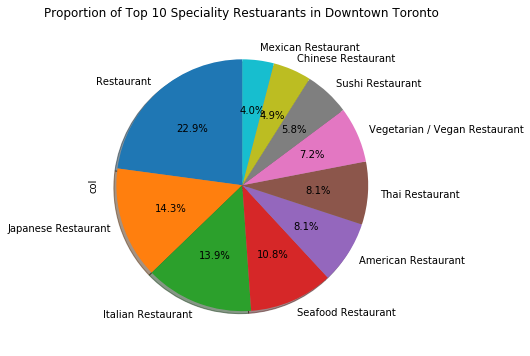

In [124]:
rest_df['col'].head(10).plot(kind='pie',
                            figsize=(5, 6),
                            autopct='%1.1f%%', 
                            startangle=90,     
                            shadow=True,            
                            )

plt.title( 'Proportion of Top 10 Speciality Restuarants in Downtown Toronto')
plt.axis('equal') 

plt.show()

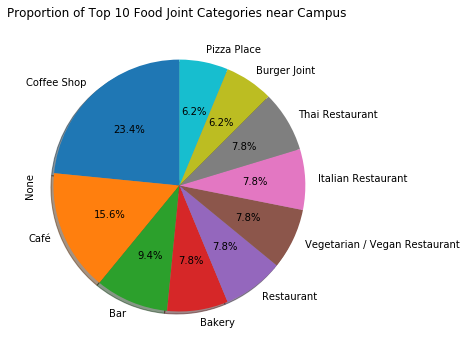

In [132]:

sum_foodsorted.head(10).plot(kind='pie',
                            figsize=(5, 6),
                            autopct='%1.1f%%', 
                            startangle=90,     
                            shadow=True,            
                            )

plt.title( 'Proportion of Top 10 Food Joint Categories near Campus ')
plt.axis('equal') 

plt.show()

Exploring Indian Restuarants near campus

In [133]:
search_query = 'Indian'
radius = 500
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, 43.6629, -79.3957, VERSION, search_query, radius, LIMIT)

In [57]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5e7a6b3598205d001b08285f'},
 'response': {'venues': [{'id': '4c7d2f9b10916dcbb99a2896',
    'name': 'Veda Healthy Indian Takeout',
    'location': {'address': '10 Kings College Rd.',
     'crossStreet': 'in Sandford Fleming',
     'lat': 43.65980608863362,
     'lng': -79.39508379136744,
     'labeledLatLngs': [{'label': 'display',
       'lat': 43.65980608863362,
       'lng': -79.39508379136744}],
     'distance': 347,
     'postalCode': 'M5S 3G4',
     'cc': 'CA',
     'city': 'Toronto',
     'state': 'ON',
     'country': 'Canada',
     'formattedAddress': ['10 Kings College Rd. (in Sandford Fleming)',
      'Toronto ON M5S 3G4',
      'Canada']},
    'categories': [{'id': '4bf58dd8d48988d10f941735',
      'name': 'Indian Restaurant',
      'pluralName': 'Indian Restaurants',
      'shortName': 'Indian',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_',
       'suffix': '.png'},
      'primary': True}],
    'referra

In [19]:
# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)
dataframe.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """


id                         name  \
0  4c7d2f9b10916dcbb99a2896  Veda Healthy Indian Takeout   
1  4afd920ff964a520ad2822e3        Indian Biriyani House   
2  4e122e6cb0fbfef99b985de1  Jodpore Club Indian Cuisine   
3  4d7c569786cfa1438065c8a0         Utsav Indian Cuisine   
4  596f9dea1fa7632be2eacab9        Mami's Indian Cuisine   

                                          categories    referralId  hasPerk  \
0  [{'id': '4bf58dd8d48988d10f941735', 'name': 'I...  v-1585080889    False   
1  [{'id': '4bf58dd8d48988d10f941735', 'name': 'I...  v-1585080889    False   
2  [{'id': '4bf58dd8d48988d10f941735', 'name': 'I...  v-1585080889    False   
3  [{'id': '4bf58dd8d48988d10f941735', 'name': 'I...  v-1585080889    False   
4  [{'id': '4bf58dd8d48988d1cb941735', 'name': 'F...  v-1585080889    False   

       location.address location.crossStreet  location.lat  location.lng  \
0  10 Kings College Rd.  in Sandford Fleming     43.659806    -79.395084   
1       181 Dundas St W     W of Chestnut St     43.655120    -79.386645   
2                   NaN                  NaN     43.655946    -79.393504   
3     69 Yorkville Ave.                  NaN     43.671154    -79.390802   
4                   NaN                  NaN     43.656986    -79.385840   

                             location.labeledLatLngs  location.distance  \
0  [{'label': 'display', 'lat': 43.65980608863362...                347   
1  [{'label': 'display', 'lat': 43.65511996683289...               1132   
2  [{'label': 'display', 'lat': 43.655946, 'lng':...                794   
3  [{'label': 'display', 'lat': 43.67115433553916...                999   
4  [{'label': 'display', 'lat': 43.65698561897954...               1031   

  location.postalCode location.cc location.city location.state  \
0             M5S 3G4          CA       Toronto             ON   
1             M5G 1C7          CA       Toronto             ON   
2                 NaN          CA       Toronto             ON   
3             M5R 1B8          CA       Toronto             ON   
4             M5G 2N2          CA       Toronto             ON   

  location.country                          location.formattedAddress  \
0           Canada  [10 Kings College Rd. (in Sandford Fleming), T...   
1           Canada  [181 Dundas St W (W of Chestnut St), Toronto O...   
2           Canada                               [Toronto ON, Canada]   
3           Canada    [69 Yorkville Ave., Toronto ON M5R 1B8, Canada]   
4           Canada                       [Toronto ON M5G 2N2, Canada]   

  location.neighborhood  
0                   NaN  
1                   NaN  
2                   NaN  
3                   NaN  
4                   NaN

In [11]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

dataframe_filtered

name         categories               address  \
0  Veda Healthy Indian Takeout  Indian Restaurant  10 Kings College Rd.   
1        Indian Biriyani House  Indian Restaurant       181 Dundas St W   
2  Jodpore Club Indian Cuisine  Indian Restaurant                   NaN   
3         Utsav Indian Cuisine  Indian Restaurant     69 Yorkville Ave.   
4        Mami's Indian Cuisine         Food Truck                   NaN   
5        Kothur Indian Cuisine  Indian Restaurant         649 Yonge St.   
6          Bhoj Indian Cuisine  Indian Restaurant       21 Davenport Rd   

           crossStreet        lat        lng  \
0  in Sandford Fleming  43.659806 -79.395084   
1     W of Chestnut St  43.655120 -79.386645   
2                  NaN  43.655946 -79.393504   
3                  NaN  43.671154 -79.390802   
4                  NaN  43.656986 -79.385840   
5                  NaN  43.667872 -79.385659   
6                  NaN  43.672765 -79.389063   

                                      labeledLatLngs  distance postalCode  cc  \
0  [{'label': 'display', 'lat': 43.65980608863362...       347    M5S 3G4  CA   
1  [{'label': 'display', 'lat': 43.65511996683289...      1132    M5G 1C7  CA   
2  [{'label': 'display', 'lat': 43.655946, 'lng':...       794        NaN  CA   
3  [{'label': 'display', 'lat': 43.67115433553916...       999    M5R 1B8  CA   
4  [{'label': 'display', 'lat': 43.65698561897954...      1031    M5G 2N2  CA   
5  [{'label': 'display', 'lat': 43.66787229558206...       979        M4Y  CA   
6  [{'label': 'display', 'lat': 43.67276456431629...      1221    M5R 1H2  CA   

      city state country                                   formattedAddress  \
0  Toronto    ON  Canada  [10 Kings College Rd. (in Sandford Fleming), T...   
1  Toronto    ON  Canada  [181 Dundas St W (W of Chestnut St), Toronto O...   
2  Toronto    ON  Canada                               [Toronto ON, Canada]   
3  Toronto    ON  Canada    [69 Yorkville Ave., Toronto ON M5R 1B8, Canada]   
4  Toronto    ON  Canada                       [Toronto ON M5G 2N2, Canada]   
5  Toronto    ON  Canada            [649 Yonge St., Toronto ON M4Y, Canada]   
6  Toronto    ON  Canada      [21 Davenport Rd, Toronto ON M5R 1H2, Canada]   

           neighborhood                        id  
0                   NaN  4c7d2f9b10916dcbb99a2896  
1                   NaN  4afd920ff964a520ad2822e3  
2                   NaN  4e122e6cb0fbfef99b985de1  
3                   NaN  4d7c569786cfa1438065c8a0  
4                   NaN  596f9dea1fa7632be2eacab9  
5  Church and Wellesley  4bedf8b5e24d20a17b567214  
6                   NaN  56c743c7498e7033ff262ce2

In [66]:
venue_id = '4c7d2f9b10916dcbb99a2896' # ID of Veda
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
url

'https://api.foursquare.com/v2/venues/4c7d2f9b10916dcbb99a2896?client_id=SVDTYH3LYUNDNYPUTAUP2XORBKWXEGGJEZOD0CUWULIMMJUG&client_secret=TANECVXBFKBHE5SNDOSJH5BO5TASHN3O1NIFKG1H44S45CWG&v=20180605'

In [67]:
result = requests.get(url).json()
print(result['response']['venue'].keys())
result['response']['venue']

dict_keys(['id', 'name', 'contact', 'location', 'canonicalUrl', 'categories', 'verified', 'stats', 'price', 'likes', 'dislike', 'ok', 'allowMenuUrlEdit', 'beenHere', 'specials', 'photos', 'reasons', 'hereNow', 'createdAt', 'tips', 'shortUrl', 'timeZone', 'listed', 'seasonalHours', 'pageUpdates', 'inbox', 'attributes'])


{'id': '4c7d2f9b10916dcbb99a2896',
 'name': 'Veda Healthy Indian Takeout',
 'contact': {'phone': '4169619797', 'formattedPhone': '(416) 961-9797'},
 'location': {'address': '10 Kings College Rd.',
  'crossStreet': 'in Sandford Fleming',
  'lat': 43.65980608863362,
  'lng': -79.39508379136744,
  'labeledLatLngs': [{'label': 'display',
    'lat': 43.65980608863362,
    'lng': -79.39508379136744}],
  'postalCode': 'M5S 3G4',
  'cc': 'CA',
  'city': 'Toronto',
  'state': 'ON',
  'country': 'Canada',
  'formattedAddress': ['10 Kings College Rd. (in Sandford Fleming)',
   'Toronto ON M5S 3G4',
   'Canada']},
 'canonicalUrl': 'https://foursquare.com/v/veda-healthy-indian-takeout/4c7d2f9b10916dcbb99a2896',
 'categories': [{'id': '4bf58dd8d48988d10f941735',
   'name': 'Indian Restaurant',
   'pluralName': 'Indian Restaurants',
   'shortName': 'Indian',
   'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_',
    'suffix': '.png'},
   'primary': True},
  {'id': '4bf58dd8d4898

In [68]:
try:
    print(result['response']['venue']['rating'])
except:
    print('This venue has not been rated yet.')

This venue has not been rated yet.


Similarly, Top 3 restuarants havent been rated yet.